# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

![alt text](Operations_Department_png/download.png)

![alt text](Operations_Department_png/download_1.png)

![alt text](Operations_Department_png/download_2.png)

# TASK #2: IMPORT LIBRARIES AND DATASET

In [3]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [4]:
# Specify training data directory
X_Ray_Directory = 'Dataset'

In [5]:
# List the folders in the directory
os.listdir(X_Ray_Directory)

['.DS_Store', '0', '1', '3', '2']

In [6]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [7]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Directory, shuffle=True,
                                                      target_size=(256,256),class_mode='categorical', subset='training')

Found 428 images belonging to 4 classes.


In [8]:
validation_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Directory, shuffle=True,
                                                      target_size=(256,256),class_mode='categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [9]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [10]:
train_images.shape

(40, 256, 256, 3)

In [11]:
train_labels.shape

(40, 4)

In [12]:
train_labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]],

In [13]:
# labels Translator
label_names = {0: 'Covid19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

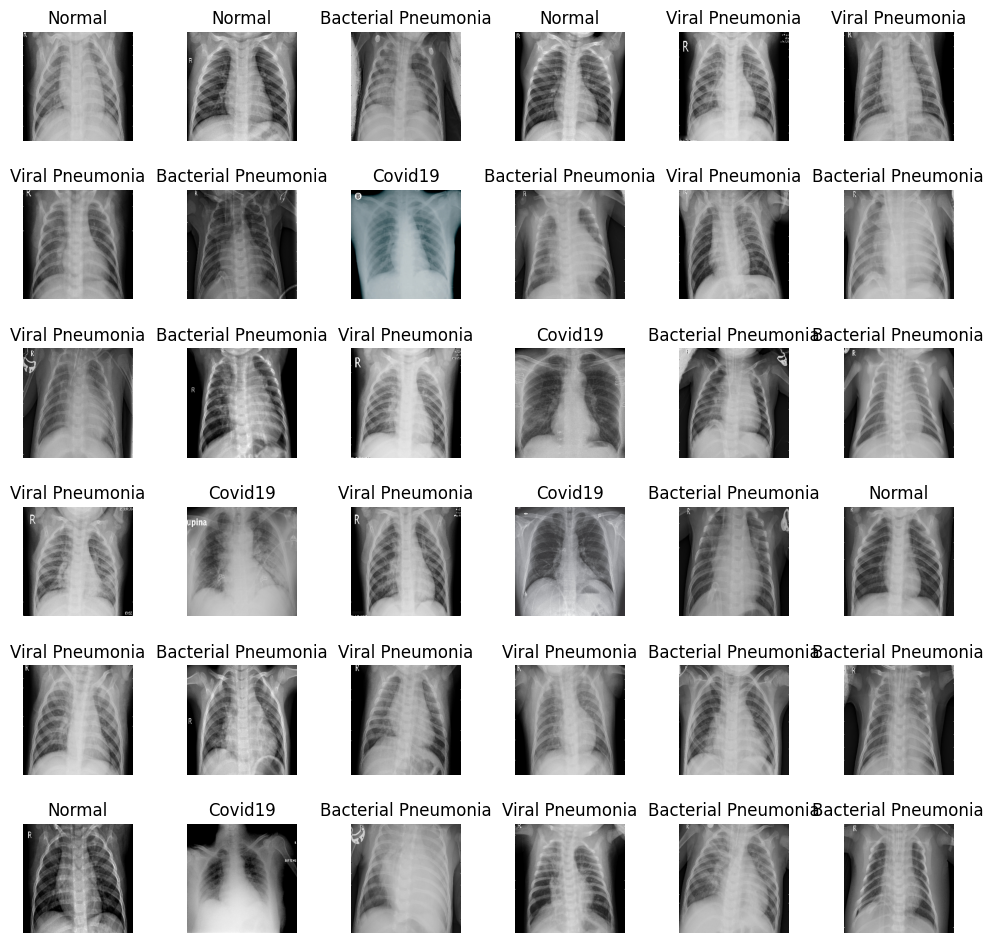

In [14]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace= 0.5)

# TASK #4: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [47]:
basemodel = ResNet50(weights= 'imagenet', include_top= False, input_tensor= Input(shape= (256, 256,3)))

In [48]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [49]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
    layers.trainable = False

# TASK #5: BUILD AND TRAIN DEEP LEARNING MODEL

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten ( name = 'flatten') (headmodel)
headmodel = Dense(256, activation='relu') (headmodel)
headmodel = Dropout(0.3) (headmodel)
headmodel = Dense(256, activation='relu') (headmodel)
headmodel = Dropout(0.3) (headmodel)
headmodel = Dense(4, activation='softmax') (headmodel)

In [51]:
model = Model(inputs = basemodel.input, outputs=headmodel)

In [52]:
model.compile(loss= 'categorical_crossentropy', optimizer= optimizers.RMSprop(learning_rate= 1e-4), metrics=[ 'accuracy'])

In [56]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor= 'val_loss', mode = 'min', patience= 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath= 'weights.h5', verbose= 1, save_best_only=True)


In [57]:
train_generator = image_generator.flow_from_directory(batch_size= 4, directory= X_Ray_Directory, shuffle=True,
                                                      target_size= (256, 256), class_mode= 'categorical', subset= 'training')


validation_generator = image_generator.flow_from_directory(batch_size= 4, directory= X_Ray_Directory, shuffle=True,
                                                      target_size= (256, 256), class_mode= 'categorical', subset= 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [65]:
history = model.fit(train_generator, epochs = 25, validation_data= validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9785 - loss: 0.1522
Epoch 1: val_loss did not improve from 11.83533
107/107 ━━━━━━━━━━━━━━━━━━━━ 87s 816ms/step - accuracy: 0.9784 - loss: 0.1523 - val_accuracy: 0.3462 - val_loss: 18.4110
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.9631 - loss: 0.0871
Epoch 2: val_loss improved from 11.83533 to 3.76819, saving model to weights.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 101s 947ms/step - accuracy: 0.9632 - loss: 0.0869 - val_accuracy: 0.5673 - val_loss: 3.7682
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.9977 - loss: 0.0068
Epoch 3: val_loss improved from 3.76819 to 0.39230, saving model to weights.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 103s 959ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.8750 - val_loss: 0.3923
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9993 - loss: 0.0031
Epoch 4: val_loss did not improve from 0.39230
107/107 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.7692 - val_loss: 1.2697
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9809 - loss: 0.1271
Epoch 5: val_loss did not improve from 0.39230
107/107 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9809 - loss: 0.1266 - val_accuracy: 0.9327 - val_loss: 0.7389
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9958 - loss: 0.0121
Epoch 6: val_loss did not improve from 0.39230
107/107 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9958 - loss: 0.0122 - val_accuracy: 0.8942 - val_loss: 0.6173
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9933 - loss: 0.0302
Epoch 7: val_loss did not improve from 0.392

# TASK #6: EVALUATE TRAINED DEEP LEARNING MODEL

In [66]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0, 0.5, 'Training accuracy and loss')

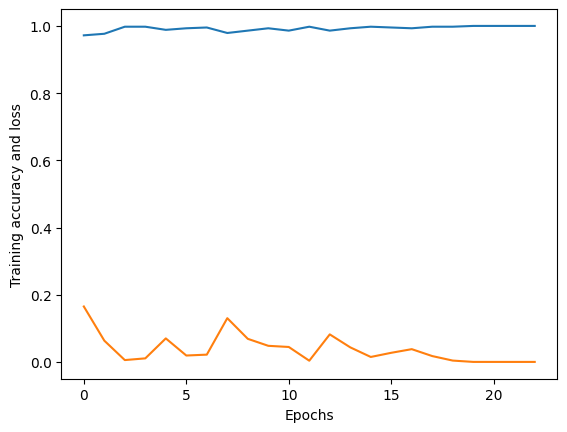

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training accuracy and loss')

Text(0, 0.5, 'Validation loss')

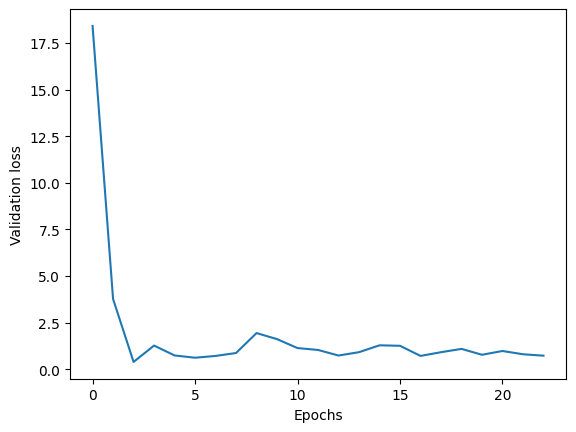

In [69]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation loss')

Text(0, 0.5, 'Validation accuracy')

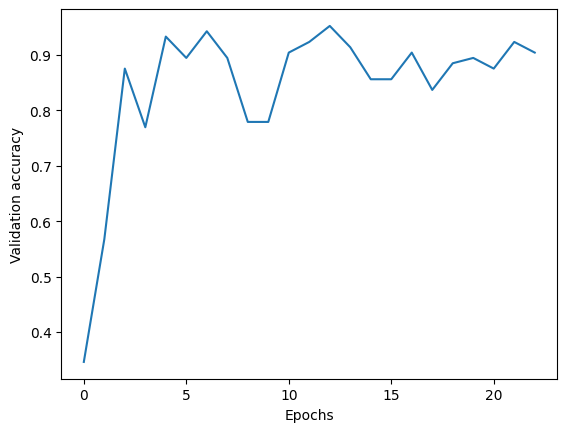

In [70]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')

In [85]:
test_directory = 'Test'

In [86]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate(test_generator, verbose=1)

print(f"Accuracy Test: {evaluate[1]}")


Found 40 images belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7750 - loss: 1.4847
Accuracy Test: 0.7749999761581421


In [104]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    class_dir = os.path.join(test_directory, str(i))
    
    # Check if the directory exists before proceeding
    if os.path.isdir(class_dir):
        for item in os.listdir(class_dir):
            img = cv2.imread(os.path.join(class_dir, item))
            img = cv2.resize(img, (256, 256))
            image.append(img)
            img = img / 255
            img = img.reshape(-1, 256, 256, 3)
            predict = model.predict(img)
            predict = np.argmax(predict)
            prediction.append(predict)
            original.append(i)
    else:
        print(f"Directory {class_dir} is missing or empty.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━

In [105]:
len(original)

40

In [106]:
score = accuracy_score(original,prediction)
print(f"Test Accuracy : {score}")

Test Accuracy : 0.8


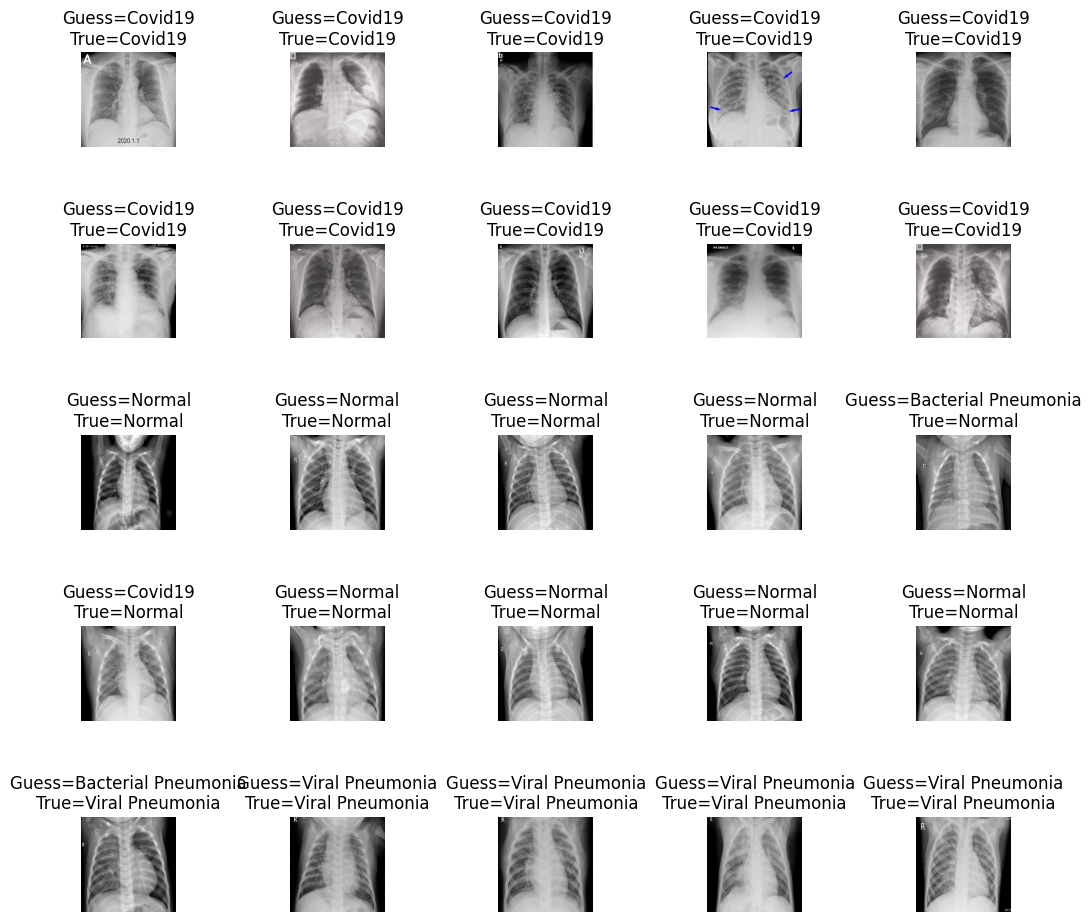

In [108]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title(f"Guess={label_names[prediction[i]]}\nTrue={label_names[original[i]]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [109]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.89      0.80      0.84        10
           2       1.00      0.50      0.67        10
           3       0.69      0.90      0.78        10

    accuracy                           0.80        40
   macro avg       0.84      0.80      0.79        40
weighted avg       0.84      0.80      0.79        40



Text(0.5, 1.0, 'Confusion_matrix')

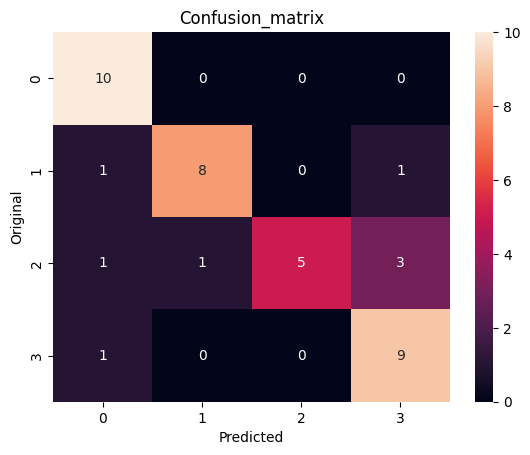

In [111]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

# EXCELLENT JOB!